# ML Models on Simulation Data with Batch

In [1]:
# use pip to install pandas, matplotlib if needed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
set_config(display="text")  # displays text representation of estimators

# survival analysis
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis


os.chdir("../")
from scr.utils import *
from scr.runSurvModels import *

# Load Data with Batch effect

### TCGA BRCA

In [2]:
brca_clin  = pd.read_csv(os.path.join("data", "batch", "TCGA_miRNA_clinical.csv"))
brca_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-BRCA-3.csv"), index_col=0)

brca_clin = brca_clin.rename(columns={'bcr_patient_barcode':'Sample'})

brca = pd.merge(brca_mirna, brca_clin, on='Sample', how = 'left')
brca_df = brca.loc[:, ['days_to_death', 
                       'days_to_last_followup'] +
                    [col for col in brca.columns if 'hsa' in col]]


# get censoring status and survival time
brca_df['status'] = [int(i) for i in ~np.isnan(brca_df['days_to_death'])]

brca_df['time'] = brca_df['days_to_death']
brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]

brca_df = brca_df.drop(columns=['days_to_death',"days_to_last_followup"])
brca_df = brca_df.dropna().reset_index(drop=True)

/tmp/ipykernel_25654/389769837.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]
/tmp/ipykernel_25654/389769837.py:16: SettingWithCop

In [45]:
brca_df = brca_df[brca_df['time']>0] 

In [49]:
train_df, test_df = train_test_split(brca_df, test_size=0.2, random_state=42, stratify=brca_df['status'])

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='time', status_col='status')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='time', status_col='status')
train_df
# parameters for fitting GB models
subset = [train_df.shape[0]]
kwargs = {'l1_ratio':0.9, 
        'alphas':[0.01],
        'max_iter':10000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName='tcga-brca')
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)

# coxnet.write(coxnet_dict)
coxnet_results

N=804 Training time (2.92s): Train C-Index: 0.963 | Test C-index: 0.67


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:99: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=10000).
  model = self.model.fit(x_train, y_train)


,n train,train time,train score,test score
0,804,2.92,0.962515,0.670153


### Simulation data with Batch

In [ ]:
surv_cols = ['t', 'delta']

In [9]:
# load simulated data
df_withBatch = pd.read_csv(os.path.join("data","batch", "demo_sim_withBatch.csv")).iloc[:, 1:]
df_noBatch   = pd.read_csv(os.path.join("data","batch", "demo_sim_noBatch.csv")).iloc[:, 1:]

df_withBatch.head()

,t,delta,A_25_P00010019,A_25_P00010020,A_25_P00010021,A_25_P00010023,A_25_P00010041,A_25_P00010042,A_25_P00010043,A_25_P00010044,...,A_25_P00016269,A_25_P00016270,A_25_P00016271,A_38_P00018874,A_38_P00018875,A_38_P00018876,A_38_P00018877,A_38_P00018878,A_38_P00018879,batch_id
0,54.77,0,5.414510,5.361662,5.310293,5.324175,5.303017,5.280794,5.155670,5.133808,...,5.464329,5.540626,5.496476,5.476537,5.370435,5.593264,5.664620,5.554928,5.877363,1
1,9.63,1,5.645660,5.628909,5.428349,5.476566,5.651610,5.433626,5.502592,5.512356,...,6.003386,6.206899,6.001569,5.825270,5.861964,6.057292,6.187139,6.776756,7.332764,1
2,35.93,0,5.556705,5.498588,5.415355,5.568460,5.446503,5.393021,5.474867,5.342807,...,5.669618,5.745632,5.669056,5.699790,5.704279,5.976060,5.899931,6.011728,6.423470,1
3,71.84,0,5.107029,4.998545,5.001954,4.976329,5.009803,4.983482,4.873145,4.878836,...,5.203232,5.211459,5.179419,4.940771,4.868911,5.083392,5.119356,5.026625,5.225131,1
4,20.52,1,5.715634,5.554129,5.560682,5.429897,5.525073,5.539028,5.455037,5.461786,...,6.043570,6.009590,6.041434,5.494935,5.562034,5.585995,5.702457,5.546448,5.863067,1


In [30]:
print("Event rate in the batch-present data: %f" % (sum(df_withBatch['delta']) / df_withBatch.shape[0]))
print("Event rate in the data without batch effect: %f" % (sum(df_noBatch['delta']) / df_noBatch.shape[0])) 

Event rate in the batch-present data: 0.760417
Event rate in the data without batch effect: 0.760417


In [ ]:
train_df, test_df = train_test_split(df_withBatch, test_size=0.2, random_state=42, stratify=df_withBatch['delta'])

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='t', status_col='delta')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='t', status_col='delta')

# parameters for fitting GB models
subset = [train_df.shape[0]]
kwargs = {'l1_ratio':1, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName='with-batch')
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)

# coxnet.write(coxnet_dict)
coxnet_results

N=76 Training time (0.56s): Train C-Index: 0.999 | Test C-index: 0.634


,n train,train time,train score,test score
0,76,0.56,0.998847,0.633721


In [35]:
train_df, test_df = train_test_split(df_noBatch, test_size=0.2, random_state=42, stratify=df_noBatch['delta'])

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='t', status_col='delta')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='t', status_col='delta')

# parameters for fitting GB models
subset = [train_df.shape[0]]
kwargs = {'l1_ratio':1, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName='no-batch')
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)

# coxnet.write(coxnet_dict)
coxnet_results

N=76 Training time (0.51s): Train C-Index: 1.0 | Test C-index: 0.913


,n train,train time,train score,test score
0,76,0.51,0.999616,0.912791


# Load Data

## Linear

Train event rate: 0.75025
Test event rate:  0.7505


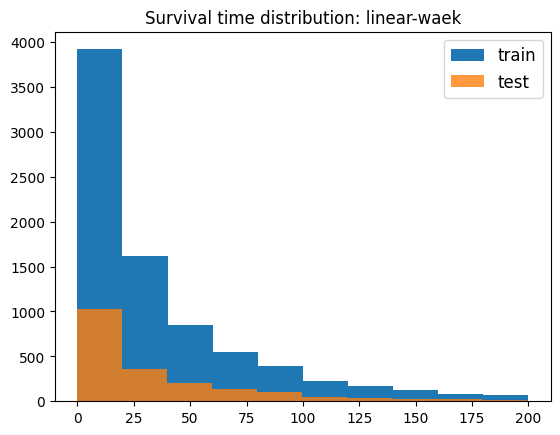

In [2]:
# prepare data
folder = 'linear'
keywords=['weak', 'latest','RW']
DATANAME = 'linear-waek'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

plt.hist(train_df['time'], label='train')
plt.hist(test_df['time'], label='test', alpha=0.8)
plt.title('Survival time distribution: %s' % DATANAME)
plt.legend(fontsize=12)
plt.show()
# plt.savefig(f"event_rate_{keyword}.png")

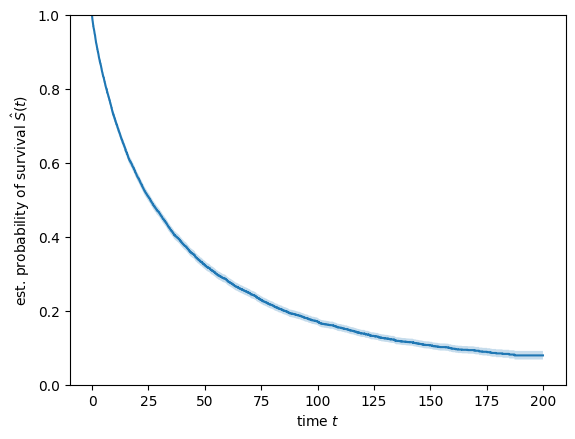

In [3]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    train_df["status"]==1, train_df["time"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

# Tree Methods

In [13]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement

# rsf_early_stopping = RandomSurvivalForest(
#     n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=42
# )
monitor = EarlyStoppingMonitor(10, 5)
# rsf_early_stopping.fit(X_train, y_train, monitor=monitor)
# print("Fitted base learners:", rsf_early_stopping.n_estimators_)
# cindex = rsf_early_stopping.score(X_test, y_test)
# print("Performance on test set", round(cindex, 3))

## Random Survival Forest

### Hyperparameter search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=RandomSurvivalForest(max_depth=3, n_estimators=500,
                                            n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [5, 15, 25],
                         'min_samples_split': [3, 10, 20]})

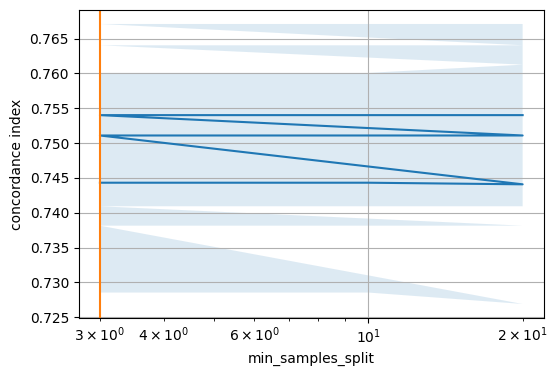

In [4]:
manual_hyperparameters = {
    # 'n_estimators': [100, 500,800],
    # 'max_depth': [3, 5, 7],
    'min_samples_split': [3,10,20],
    'min_samples_leaf': [5,15,25]
}
# parameters for fitting RSF models
kwargs = {
    'n_estimators':500,
    'max_depth': 3,
    # 'min_samples_split':10,
    # 'min_samples_leaf':15,
    'n_jobs':0, 
    'random_state':42
}
rsf = RandomSurvivalForestModel(X_train[:1000], y_train[:1000], X_test, y_test,
                                hyperparameters=manual_hyperparameters)
rsf.build_model(**kwargs)
search = rsf.tune_hyperparameters(n_split=5, plotting_param='min_samples_split')
search

In [6]:
rsf.model

RandomSurvivalForest(max_depth=3, min_samples_leaf=25, min_samples_split=3,
                     n_estimators=500, n_jobs=-1, random_state=42)

### Training

In [7]:
# parameters for fitting RSF models
# output_dir = os.path.join('models',keyword, 'rsf')
subset = [
  50,200,500,1000,2000,#5000,#8000
]
kwargs = {'n_estimators':500, 
          'min_samples_split':10,
        'min_samples_leaf':15,
        'n_jobs':1, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results, rsf_dict = rsf.train(subset=subset)
# rsf.write(rsf_dict)

N=50 Training time (0.71s): Train C-Index: 0.807 | Test C-index: 0.505
N=200 Training time (5.63s): Train C-Index: 0.829 | Test C-index: 0.498
N=500 Training time (52.0s): Train C-Index: 0.857 | Test C-index: 0.497
N=1000 Training time (340.53s): Train C-Index: 0.869 | Test C-index: 0.505
N=2000 Training time (1264.0s): Train C-Index: 0.869 | Test C-index: 0.501


## Gradient Boosting

### Hyperparameter Search

In [ ]:
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.1, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

In [16]:
gb_kwargs = {
    'n_estimators':500, 
    # 'n_jobs':-1, 
    'random_state':42
}
gb_hyperparameters = {
    'learning_rate': [0.1, 0.9],
    'max_depth': [1, 5, 10]
}

gb =  GradientBoostingSurvivalModel(X_train[:500], y_train[:500], X_test, y_test,
                                    hyperparameters=gb_hyperparameters)
gb.build_model(**gb_kwargs)
gb_cv = gb.tune_hyperparameters(n_split=5)
pd.DataFrame(gb_cv.cv_results_)

/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,78.987563,0.940394,0.018028,0.028702,0.1,1,"{'learning_rate': 0.1, 'max_depth': 1}",0.830909,0.816364,0.804242,0.841818,0.822626,0.823192,0.012748,1
1,246.343846,4.950607,0.005623,0.000440,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",0.810505,0.809899,0.789697,0.796768,0.790707,0.799515,0.009057,4
2,309.232191,4.486070,0.009736,0.000189,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.748081,0.759192,0.746263,0.718384,0.754747,0.745333,0.014250,6
3,78.518984,1.109372,0.003462,0.000050,0.9,1,"{'learning_rate': 0.9, 'max_depth': 1}",0.811111,0.804040,0.812121,0.808485,0.807273,0.808606,0.002873,3
4,244.037484,6.315745,0.005808,0.000743,0.9,5,"{'learning_rate': 0.9, 'max_depth': 5}",0.827879,0.820202,0.809091,0.812121,0.806667,0.815192,0.007815,2
5,336.418411,25.017336,0.010486,0.000395,0.9,10,"{'learning_rate': 0.9, 'max_depth': 10}",0.767273,0.782828,0.763434,0.729495,0.754343,0.759475,0.017590,5


### Training

In [17]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000#,8000
]
kwargs = {'n_estimators':500, 
        'learning_rate':0.1,
        'max_depth':1,
        # 'n_jobs':-1, 
        'random_state':42}
gb = GradientBoostingSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
gb.build_model(**kwargs)
gb_results, gb_dict = gb.train(subset=subset)
gb.write(gb_dict)

N=50 Training time (2.15s): Train C-Index: 0.998 | Test C-index: 0.693
N=200 Training time (9.68s): Train C-Index: 0.926 | Test C-index: 0.755
N=500 Training time (26.79s): Train C-Index: 0.871 | Test C-index: 0.771
N=1000 Training time (60.16s): Train C-Index: 0.838 | Test C-index: 0.773
N=2000 Training time (142.34s): Train C-Index: 0.813 | Test C-index: 0.781
N=5000 Training time (499.89s): Train C-Index: 0.797 | Test C-index: 0.788


# CoxNet models

### Hyperparameter Search: Manual

/tmp/ipykernel_326640/3953593320.py:1: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)


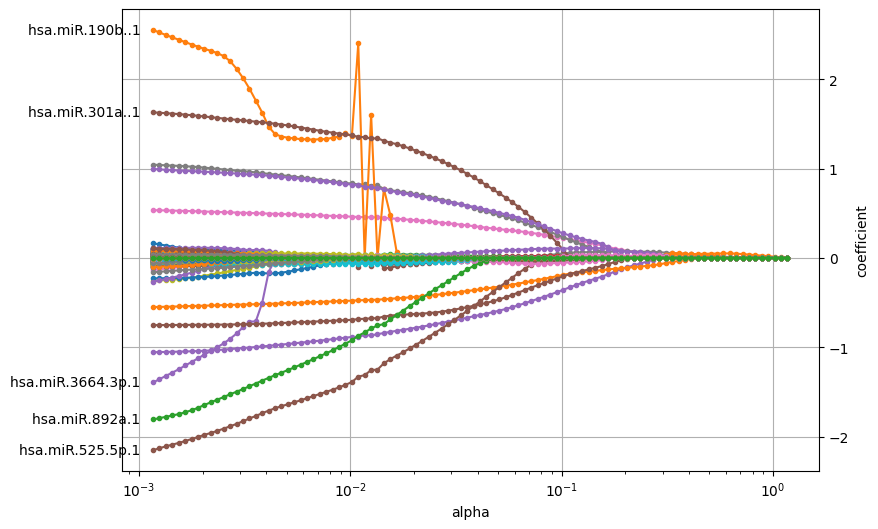

In [37]:
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)
coefficients = pd.DataFrame(coxnet.coef_, index=train_df.columns[:-3], columns=np.round(coxnet.alphas_, 5))
plot_coefficients(coefficients, n_highlight=5)

In [ ]:
# alphas =  10 ** np.linspace(-3, 3, 7) #coxnet.alphas_

# cph_hyperparameters={
#     "alpha": [a for a in alphas],
# }

# cph = CoxPHModel(X_train, y_train, X_test, y_test,
#                             hyperparameters=cph_hyperparameters)
# cph.build_model()
# cph_cv = cph.tune_hyperparameters(n_split=5, plotting_param = "alpha")
# pd.DataFrame(cph_cv)

In [1]:
alphas =  [0.1, 10] #coxnet.alphas_

coxnet_hyperparameters={
    "alphas": [[a] for a in alphas],
    'l1_ratio': [0.1, 0.9]
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test,
                            hyperparameters=coxnet_hyperparameters)
coxnet.build_model()
cv_results = coxnet.tune_hyperparameters(n_split=5, plotting_param='alphas')
# cv_results = pd.DataFrame(coxnet.cv_results_)
cv_results

NameError: name 'CoxPHElasticNetModel' is not defined

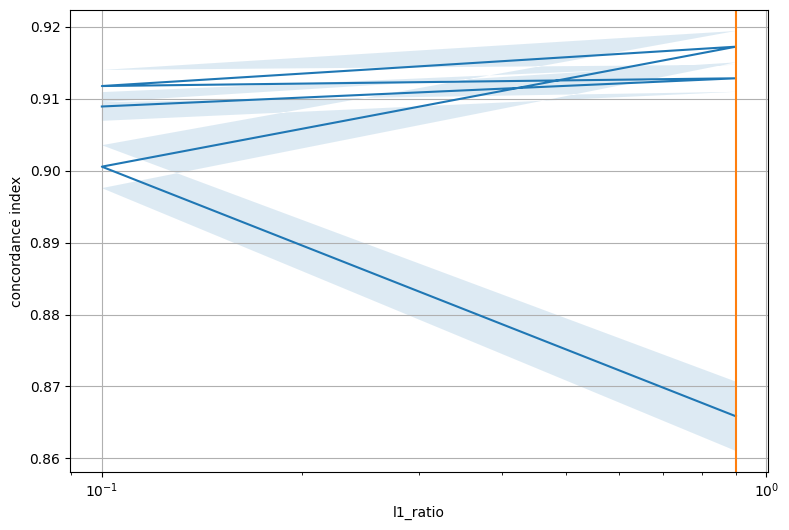

In [37]:
param = 'l1_ratio'
try:
    params = cv_results[f'param_{param}'].map(lambda x: x[0])
except TypeError:
    params = cv_results[f'param_{param}']
mean = cv_results.mean_test_score
std = cv_results.std_test_score


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(params, mean)
ax.fill_between(params, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_xlabel(param)
ax.set_ylabel("concordance index")
ax.axvline(coxnet_cv.best_params_[param][0] 
            if isinstance(coxnet_cv.best_params_[param], list)
            else coxnet_cv.best_params_[param], 
        c="C1")
ax.grid(True)

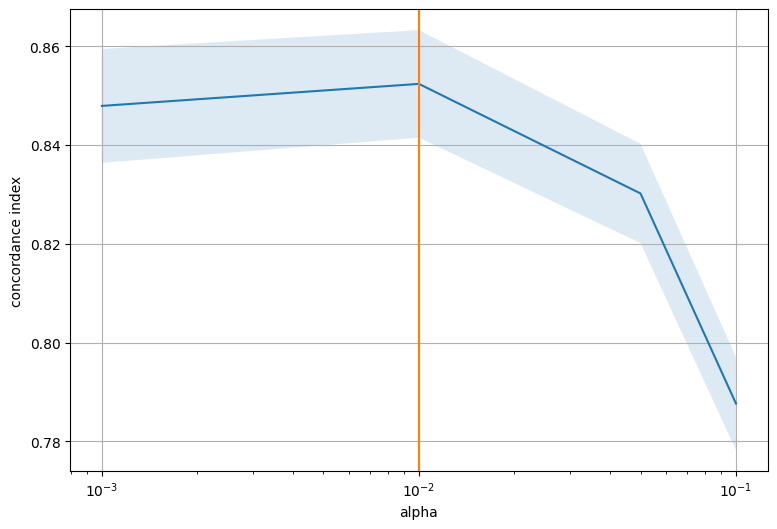

In [50]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(coxnet_cv.best_params_["alphas"][0], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [36]:
coxnet_cv.best_estimator_

CoxnetSurvivalAnalysis(alphas=[0.01], l1_ratio=0.9)

### Testing the modeling pipeline: hyperparam search

In [ ]:
coxnet = CoxPHElasticNetModel(X_train[:1000], y_train[:1000], X_test, y_test)
coxnet.build_model()
search = coxnet.tune_hyperparameters(n_split=5, plotting_param='l1_ratio')

### Training model with best parameter

In [ ]:
# parameters for fitting CoxPH Elastic Net regression models
subset=[
        50,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':1, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)

coxnet.write(coxnet_dict)
coxnet_results

/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=50 Training time (0.54s): Train C-Index: 0.998 | Test C-index: 0.582


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=500 Training time (3.08s): Train C-Index: 0.641 | Test C-index: 0.621


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (8.31s): Train C-Index: 0.499 | Test C-index: 0.525


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=2000 Training time (15.59s): Train C-Index: 0.497 | Test C-index: 0.469


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=5000 Training time (62.36s): Train C-Index: 0.526 | Test C-index: 0.535
N=8000 Training time (5.05s): Train C-Index: 0.72 | Test C-index: 0.709


,n train,train time,train score,test score
0,50,0.54,0.997998,0.581807
1,500,3.08,0.640698,0.620533
2,1000,8.31,0.498528,0.525049
3,2000,15.59,0.496710,0.468581
4,5000,62.36,0.526188,0.534856
5,8000,5.05,0.720460,0.709187


In [7]:
coxnet_results.to_csv(os.path.join('models', DATANAME, 'coxnet','model.results.1030.txt'))

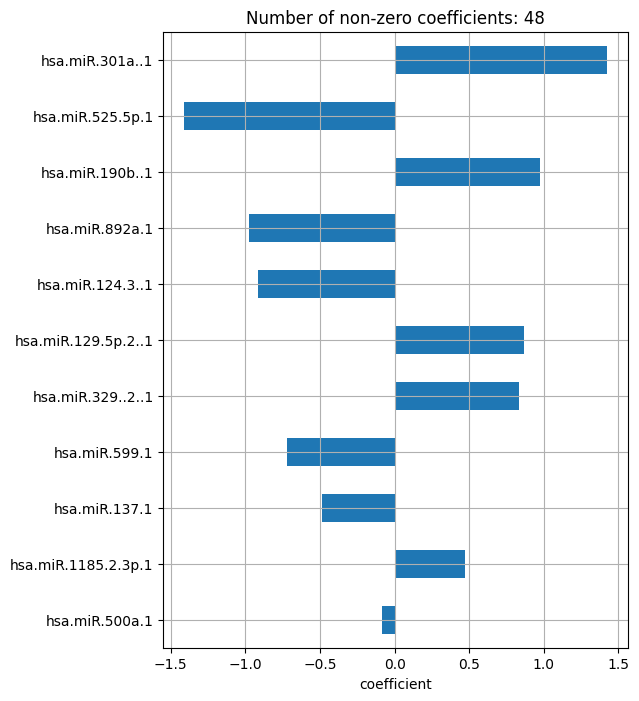

In [8]:
coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet_dict['8000'].coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 5e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)
ax.set_title(f"Number of non-zero coefficients: {non_zero}")
fig.savefig(
    os.path.join("models",DATANAME, 'coxnet','top-coefficients.jpg')
)

# Baseline: CoxPH Models

### Hyperparameter search

In [19]:
alphas = 10.0 ** np.linspace(-4, 4, 10)
coefficients = {}
cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train, y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X_train.columns)
plot_coefficients(coefficients, n_highlight=5)

/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:470: RuntimeWarning: invalid value encountered in scalar divide
  res = np.abs(1 - (loss_new / loss))
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:194: RuntimeWarning: overflow encountered in exp
  exp_xw = np.exp(offset + np.dot(x, w))
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:223: RuntimeWarning: invalid value encountered in multiply
  risk_set_x2 += exp_xw[k] * xk
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:224: RuntimeWarning: invalid value encountered in multiply
  risk_set_xx2 += exp_xw[k] * xx
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:238: RuntimeWarning: invalid value en

ValueError: LAPACK reported an illegal value in 5-th argument.

In [13]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':0.001, 
        'alphas': [1e-2],
        'max_iter':20000}
cph = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
cph.build_model(**kwargs)
cph_results, cph_dict = cph.train(subset=subset)
cph_results
# coxnet.write(coxnet_dict)

/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=50 Training time (1.57s): Train C-Index: 0.73 | Test C-index: 0.67
N=200 Training time (0.62s): Train C-Index: 0.976 | Test C-index: 0.743


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=500 Training time (8.22s): Train C-Index: 0.919 | Test C-index: 0.777


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (15.45s): Train C-Index: 0.884 | Test C-index: 0.799


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=2000 Training time (38.2s): Train C-Index: 0.64 | Test C-index: 0.655


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=5000 Training time (102.71s): Train C-Index: 0.848 | Test C-index: 0.832
N=8000 Training time (53.3s): Train C-Index: 0.846 | Test C-index: 0.836


,n train,train time,train score,test score
0,50,1.57,0.730359,0.670015
1,200,0.62,0.975636,0.743456
2,500,8.22,0.918693,0.777148
3,1000,15.45,0.883972,0.799484
4,2000,38.20,0.640261,0.655225
5,5000,102.71,0.848316,0.831628
6,8000,53.30,0.845935,0.836186


In [15]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'alpha': 0.9}
cph = CoxPHModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
cph.build_model(**kwargs)
cph_results, cph_dict = cph.train(subset=subset)
cph_results
# coxnet.write(coxnet_dict)

N=50 Training time (5.04s): Train C-Index: 1.0 | Test C-index: 0.653
N=200 Training time (21.79s): Train C-Index: 0.988 | Test C-index: 0.735
N=500 Training time (47.02s): Train C-Index: 0.964 | Test C-index: 0.757


KeyboardInterrupt: 